# Проверка гипотез по увеличению выручки интернет-магазина

**Цель исследования**

Цель данного проекта состоит в проверке гипотез по увеличению выручки интернет-магазина. Для этого мы проведем приоритизацию полученных от отдела маркетинга гипотез и запустим A/B-тест. По результатам теста мы примем решение о том, стоит ли нам: 
1. Остановить тест и зафиксировать победу одной из групп;
2. Остановить тест и зафиксировать отсутствие различий между группами;
3. Продолжить тест.


**Описание данных**

Данные представлены 3-мя датасетами:

* hypothesis.csv
* orders.csv
* visitors.csv

Структура hypothesis.csv:
* Hypothesis — краткое описание гипотезы;
* Reach — охват пользователей по 10-балльной шкале;
* Impact — влияние на пользователей по 10-балльной шкале;
* Confidence — уверенность в гипотезе по 10-балльной шкале;
* Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Структура orders.csv:
* transactionId — идентификатор заказа;
* visitorId — идентификатор пользователя, совершившего заказ;
* date — дата, когда был совершён заказ;
* revenue — выручка заказа;
* group — группа A/B-теста, в которую попал заказ.

Структура visitors.csv:
* date — дата;
* group — группа A/B-теста;
* visitors — количество пользователей в указанную дату в указанной группе A/B-теста




**План исследования**

1. Загрузка и подготовка данных.

Загрузим данные, изучим общую информацию о датафрейме и проведем предобработку. 

2. Приоритизация гипотез.

Проведем приоритизацию гипотез по методам ICE и RICE. 

3. Анализ A/B-теста.

Проанализируем A/B-тест, посчитаем статистическую значимость между такими показателями групп, как средний чек заказа и среднее количестве заказов на посетителя, при необходимости проведем очистку данных. Сделаем выводы по результатам теста. 

###  Загрузка данных и их подготовка к анализу

In [1]:
import pandas as pd
pd.options.display.max_colwidth = 400
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

#### Загрузим и изучим данные 

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')

In [3]:
orders = pd.read_csv('/datasets/orders.csv')

In [4]:
visitors = pd.read_csv('/datasets/visitors.csv')

In [5]:
hypothesis.head()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


In [6]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [7]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [8]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [9]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [10]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Пропусков не обнаружено, но требуется привести формат данных в столбцах  'date' таблиц orders и visitors к типу datetime и убрать заглавные буквы в названиях столбцов.

#### Проведем предобработку

Поправим названия столбцов

In [11]:
hypothesis.columns = hypothesis.columns.str.lower()

In [12]:
orders.columns = orders.columns.str.lower()

In [13]:
visitors.columns = visitors.columns.str.lower()

Поменяем формат данных в столбцах 'date' таблиц orders и visitors.

In [14]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [15]:
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

Проверим данные на наличие дубликатов

In [16]:
hypothesis.duplicated().sum()

0

In [17]:
orders.duplicated().sum()

0

In [18]:
visitors.duplicated().sum()

0

Дубликатов не обнаружено

Теперь проверим нет ли пользователей, попавших в обе группы.

In [19]:
orders_a = orders[orders['group'] == 'A']
orders_b = orders[orders['group'] == 'B']
wrong_users = orders_a[orders_a['visitorid'].isin(orders_b['visitorid'])]['visitorid'].unique()
print(f'Число "неправильных" покупателей: {wrong_users.size}')

Число "неправильных" покупателей: 58


Посчитаем число уникальных покупателей.

In [20]:
print('Число уникальных покупателей: ', orders['visitorid'].nunique())

Число уникальных покупателей:  1031


Удалим "неправильных" пользователей

In [21]:
orders = orders[~(orders['visitorid'].isin(wrong_users))]

In [22]:
# Проверим
print('Число уникальных покупателей: ', orders['visitorid'].nunique())

Число уникальных покупателей:  973


In [23]:
hypothesis.head()

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


In [24]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [25]:
orders.head()

,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B


In [26]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionid  1016 non-null   int64         
 1   visitorid      1016 non-null   int64         
 2   date           1016 non-null   datetime64[ns]
 3   revenue        1016 non-null   int64         
 4   group          1016 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 47.6+ KB


In [27]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [28]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


Пропусков и дубликатов не обнаружено, тип данных скорректирован, данные готовы к работе.

###  Приоритизация гипотез

#### Проведем приоритизацию гипотез по методу ICE

Метод ICE состоит из 3-х компонент: 
* Impact — насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта;
* Confidence — насколько вы уверены, что это изменение повлияет на пользователей именно так; 
* Efforts — сколько стоит протестировать эту гипотезу. 

Формула: ICE = Impact * Confidence / Efforts

In [29]:
hypothesis['ice'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts'] 
hypothesis[['hypothesis','ice']].sort_values(by='ice', ascending=False)

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


#### Проведем приоритизацию гипотез по методу RICE

Метод RICE имеет дополнительную четвертую компоненту - Reach — скольких пользователей затронет изменение, которое вы хотите внести. 

Формула: RICE = Reach * Impact * Confidence / Efforts

In [30]:
hypothesis['rice'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts'] 
hypothesis[['hypothesis', 'reach', 'rice']].sort_values(by='rice', ascending=False)

,hypothesis,reach,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,3.0


#### Выводы по приоритизации гипотез 

Если по методу ICE приоритет был у гипотез под номерами 8, 0 и 7, то по методу RICE на 1-е место попала гипотеза номер 7 (с 3-го места), 2-е место у гипотезы номер 2 (было 5-е), 3-е место делят гипотезы под номерами 0 (было 2-е) и 6 (было 4-е). Изменение приоритизации связано с тем, что метод RICE помимо параметров ICE учитывает еще и охват гипотез, так гипотеза 7 имеет наиболее полный охват - 10. По методу RICE гипотеза 7 набрала 112 баллов - в 2 раза больше, чем у следующей за ней гипотезы номер 2 (56 баллов).
Таким образом наиболее предпочтительной выглядит гипотеза номер 7.

###  Анализ A/B-теста

#### Построим график кумулятивной выручки по группам 

Создадим массив уникальных пар значений дат и групп теста

In [31]:
dates_groups = orders[['date','group']].drop_duplicates() 

Соберем агрегированные кумулятивные по дням данные о заказах

In [32]:
orders_aggregated = dates_groups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transactionid': 'nunique',
            'visitorid': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])
orders_aggregated

,date,group,transactionid,visitorid,revenue
55,2019-08-01,A,23,19,142779
66,2019-08-01,B,17,17,59758
175,2019-08-02,A,42,36,234381
173,2019-08-02,B,40,39,221801
291,2019-08-03,A,66,60,346854
...,...,...,...,...,...
533,2019-08-29,B,510,490,4746610
757,2019-08-30,A,460,437,3311413
690,2019-08-30,B,531,511,4955833
958,2019-08-31,A,468,445,3364656


Аналогично соберем агрегированные кумулятивные по дням данные о пользователях

In [33]:
visitors_aggregated = dates_groups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])
visitors_aggregated

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845
...,...,...,...
533,2019-08-29,B,17708
757,2019-08-30,A,18037
690,2019-08-30,B,18198
958,2019-08-31,A,18736


Объединим обе таблицы с агрегированными данными в одну и поменяем названия столбцов

In [34]:
cumulative_data = orders_aggregated.merge(
    visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulative_data.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]
cumulative_data

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845
...,...,...,...,...,...,...
57,2019-08-29,B,510,490,4746610,17708
58,2019-08-30,A,460,437,3311413,18037
59,2019-08-30,B,531,511,4955833,18198
60,2019-08-31,A,468,445,3364656,18736


Построим графики кумулятивной выручки по дням и группам A/B-тестирования

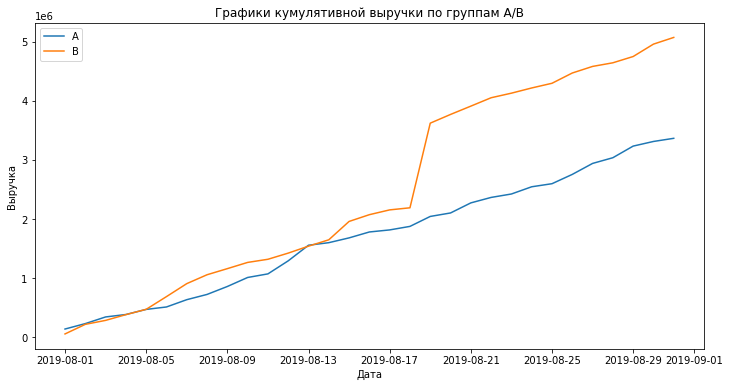

In [35]:
# датафреймы с кумулятивным количеством заказов и кумулятивной выручкой по дням для групп А и B
cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]
cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(12,6))
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label = 'A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label = 'B')
plt.ylabel('Выручка')
plt.xlabel('Дата')
plt.title('Графики кумулятивной выручки по группам A/B')
plt.legend()
plt.show()

Группа В показывает более высокую выручку почти на всем протяжении теста. При этом 13 августа выручка по группам сравнивается, а 19 августа происходит скачок выручки в группе В, возможно 19-го числа был крупный заказ?. Рассмотрим данные за 19-е число.

In [36]:
orders[(orders['date'] == '2019-08-19') & (orders['group'] == 'B')].sort_values(by='revenue', ascending=False).head()

,transactionid,visitorid,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
527,1570513684,2837914161,2019-08-19,33405,B
461,2683113224,154576532,2019-08-19,26550,B
368,3268879337,2536252163,2019-08-19,20026,B
463,4170537404,290022471,2019-08-19,16480,B


Так и есть, крупный заказ заметно исказил график, учтем это в дальнейшем.

#### Построим график кумулятивного среднего чека по группам

Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов

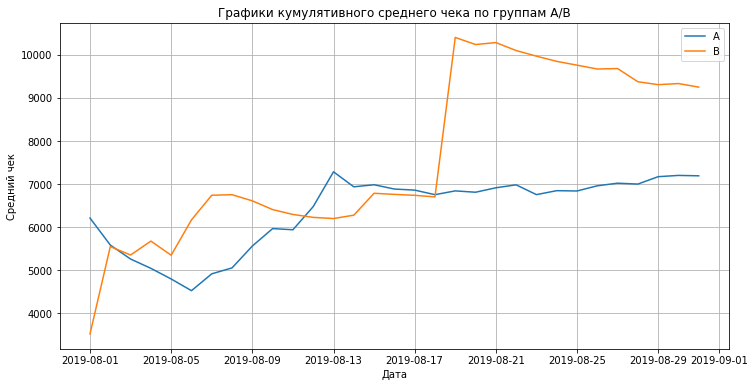

In [37]:
plt.figure(figsize=(12,6))
plt.grid()
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue']/cumulative_revenue_a['orders'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue']/cumulative_revenue_b['orders'], label='B')
plt.ylabel('Средний чек')
plt.xlabel('Дата')
plt.title('Графики кумулятивного среднего чека по группам A/B')
plt.legend()
plt.show()

Средний чек группы В больше чека группы А со 2-го по 11-е августа, с 12 по 18 группа А вырывается вперед, с 19 августа впереди группа В. При этом вновь хорошо виден выброс 19-го августа. После 19-го числа средний чек по группе В снижается, а по группе А наоборот несколько растет.

#### Построим график относительного изменения кумулятивного среднего чека группы B к группе A

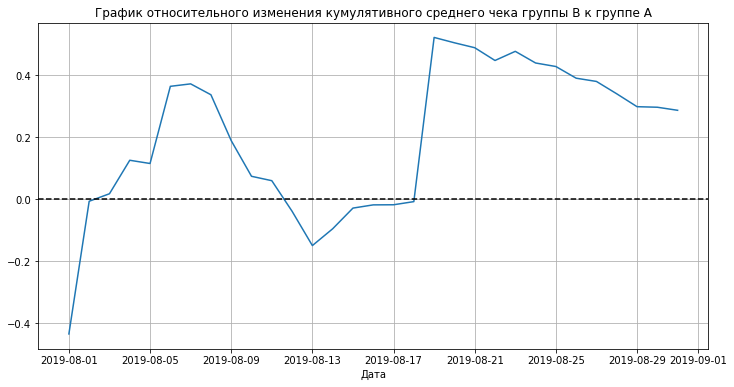

In [38]:
# собираем данные в одном датафрейме
merged_cumulative_revenue = cumulative_revenue_a.merge(
    cumulative_revenue_b, left_on='date', right_on='date', how='left', suffixes=['_a', '_b'])

plt.figure(figsize=(12,6))
plt.grid()
plt.plot(merged_cumulative_revenue['date'], (
    merged_cumulative_revenue['revenue_b']/merged_cumulative_revenue['orders_b'])/
    (merged_cumulative_revenue['revenue_a']/merged_cumulative_revenue['orders_a'])-1)
plt.axhline(y=0, color='black', linestyle='--') 
plt.xlabel('Дата')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.show()

Средний чек группы В растет относительно группы А до 7-го августа, затем падает до 13-го и с 14-го по 19-е (где мы вновь наблюдаем выброс) растет, после 19-го наблюдается спад. В целом все три графика показывают сходную картину и говорят нам о необходимости отфильтровать выбросы. 

#### Построим график кумулятивного среднего количества заказов на посетителя по группам

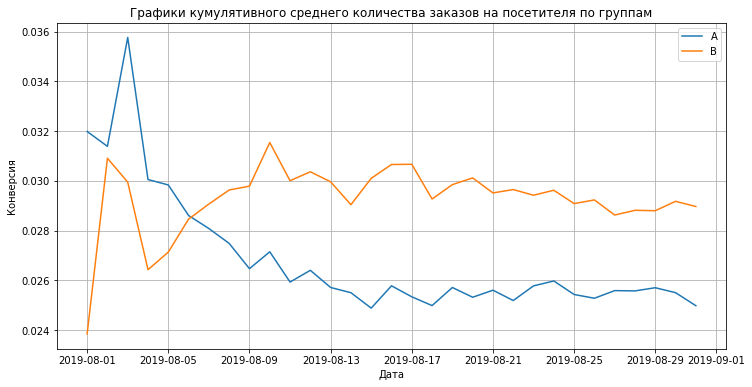

In [39]:
# считаем среднее количество заказов на посетителя
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']

# разделяем данные по группам
cumulative_data_a = cumulative_data[cumulative_data['group']=='A']
cumulative_data_b = cumulative_data[cumulative_data['group']=='B']

plt.figure(figsize=(12,6))
plt.grid()
plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label='B')
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.title('Графики кумулятивного среднего количества заказов на посетителя по группам')
plt.show()

Группа А показывает максимальную конверсию 3-го числа, после чего падает и с 13-го числа колеблется на одном уровне - 0.25-0.26. Группа В растет с 1-го по 2-е, затем падает, после 4-го растет и достигает пика 10-го числа. После 10-го августа конверсия группы В снижается, за исключением скачка 14-17 числа, где она приближается к 0.31, конверсия группы В устанавливается на уровне 0.29. При этом с 6-го августа и до конца месяца конверсия группы В стабильно выше группы А.

#### Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

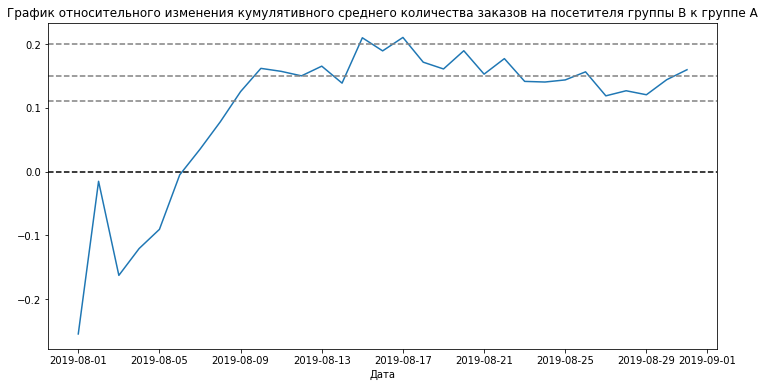

In [40]:
merged_cumulative_conversions = cumulative_data_a[['date','conversion']].merge(
    cumulative_data_b[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['_a', '_b'])

plt.figure(figsize=(12,6))
plt.plot(merged_cumulative_conversions['date'], 
         merged_cumulative_conversions['conversion_b']/merged_cumulative_conversions['conversion_a']-1, 
         label="Относительный прирост кумулятивного среднего количества заказов на посетителя группы B относительно группы A")
plt.xlabel('Дата')
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.11, color='grey', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.show()

Как и на предыдущем графике - скачок 2 числа - однако группа В все еще меньше (на 1%) группы А, затем падение до 3-го, рост и с 6-го числа конверсия группы В выше группы А. Пик относительно группы А наблюдается 15-17 августа - конверсия группы В выше на 20-21%, после чего наблюдается падение, но конверсия В продолжает превышать А на 11-15%.

#### Построим точечный график количества заказов по пользователям

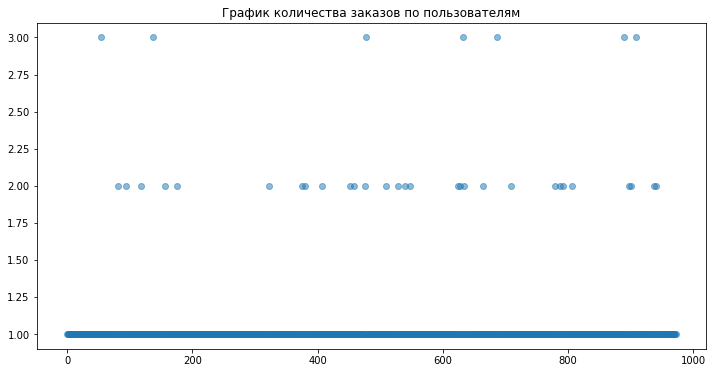

In [41]:
orders_by_users = (
    orders.groupby('visitorid', as_index=False)
    .agg({'transactionid': 'nunique'})
)
orders_by_users.columns = ['visitorid', 'orders']

# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(orders_by_users)))

plt.figure(figsize=(12,6))
plt.scatter(x_values, orders_by_users['orders'], alpha=0.5) 
plt.title('График количества заказов по пользователям')
plt.show()

Большая часть пользователей совершает по 1-му заказу, по 2 заказа - куда меньше, 3 - редкость. 

#### Посчитаем 95-й и 99-й перцентили количества заказов на пользователя

In [42]:
percentile = np.percentile(orders_by_users['orders'], [95, 99])
print(f'95-й перцентиль: {percentile[0]}, 99-й перцентиль: {percentile[1]}')

95-й перцентиль: 1.0, 99-й перцентиль: 2.0


Рассчитаем также 96-й, 97-й и 98-й перцентили.

In [43]:
percentile = np.percentile(orders_by_users['orders'], [96, 97, 98])
print(f'96-й перцентиль: {percentile[0]}, 97-й перцентиль: {percentile[1]}, 98-й перцентиль: {percentile[2]}')

96-й перцентиль: 1.0, 97-й перцентиль: 2.0, 98-й перцентиль: 2.0


Как минимум 96 % пользователей делают 1 заказ, все что выше можно считать аномалией. 

#### Построим точечный график стоимостей заказов

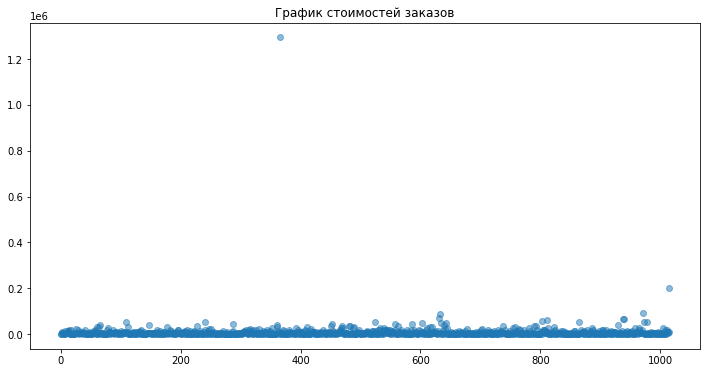

In [44]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.figure(figsize=(12,6))
plt.scatter(x_values, orders['revenue'], alpha=0.5) 
plt.title('График стоимостей заказов')
plt.show()

Явно виден тот самый заказ от 19 августа на 1294500. Скорректируем график, убрав явные выбросы.

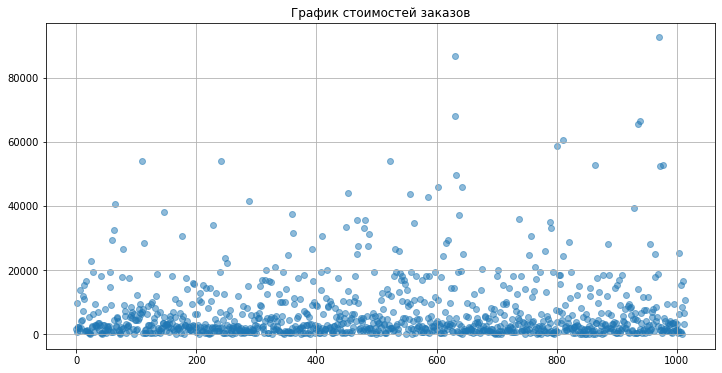

In [45]:
corr_orders = orders[orders['revenue'] < 200000]['revenue']
xn_values = pd.Series(range(0, len(corr_orders)))
plt.figure(figsize=(12,6))
plt.grid()
plt.title('График стоимостей заказов')
plt.scatter(xn_values, corr_orders, alpha=0.5);

Большая часть заказов в пределах 20000, от 20000 до 40000 уже заметно меньше, все что выше - большая редкость.

#### Посчитаем 95-й и 99-й перцентили стоимости заказов

In [46]:
percentile = np.percentile(orders['revenue'], [95, 99])
print(f'95-й перцентиль: {percentile[0]:.1f}, 99-й перцентиль: {percentile[1]:.1f}')

95-й перцентиль: 26785.0, 99-й перцентиль: 53904.0


In [47]:
percentile = np.percentile(orders['revenue'], [96, 97, 98])
print(f'96-й перцентиль: {percentile[0]:.1f}, 97-й перцентиль: {percentile[1]:.1f}, 98-й перцентиль: {percentile[2]:.1f}')

96-й перцентиль: 30649.0, 97-й перцентиль: 34792.0, 98-й перцентиль: 42353.0


In [48]:
revenue_lim = np.percentile(orders['revenue'], 95)

Примем за верхнюю границу 95-й перцентиль - 26785.

#### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

Посчитаем число посетителей за день по группам.

In [49]:
visitors_a_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_a_daily.columns = ['date', 'visitors_per_date']

visitors_b_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_b_daily.columns = ['date', 'visitors_per_date']

Посчитаем число заказов для каждого пользователя, совершившего хотя бы один заказ, по группам.

In [50]:
orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)
orders_by_users_a.columns = ['userid', 'orders']

orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)
orders_by_users_b.columns = ['userid', 'orders']

Соберем выборки sample_a и sample_b в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули.

In [51]:
sample_a = pd.concat(
    [
        orders_by_users_a['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors_a_daily['visitors_per_date'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b = pd.concat(
    [
        orders_by_users_b['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors_b_daily['visitors_per_date'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

H0: различий в среднем количестве заказов на посетителя между группами нет. 

H1: различия в среднем количестве заказов на посетителя между группами есть. 

Примем уровень значимости за 0.05.

In [52]:
print(f'P-value: {stats.mannwhitneyu(sample_a, sample_b)[1]:.3f}')

print(f'Относительное различие в конверсии между группами: {sample_b.mean() / sample_a.mean() - 1:.3f}')

P-value: 0.011
Относительное различие в конверсии между группами: 0.160


P-value меньше уровня значимости, отвергаем нулевую гипотезу в пользу альтернативной - различия в конверсии между группами есть. Относительный выигрыш группы B над группой A равен 16%.

#### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным

H0: различий в среднем чеке между группами нет. 

H1: различия в среднем чеке между группами есть.

Примем уровень значимости за 0.05.

In [53]:
print('P-value: {0:.3f}'.format(
    stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Относительное различие в среднем чеке между группами: {0:.3f}'.format(
    orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

P-value: 0.829
Относительное различие в среднем чеке между группами: 0.287


Наблюдаемое различие в 28.7% не является статистически значимым - P-value заметно больше уровня значимости. Соответственно причин отвергать нулевую гипотезу в пользу альтернативной нет - различий в среднем чеке между группами нет. Наблюдаемое различие вероятно связано с выбросами, требуется очистить данные и провести повторный расчет. 

#### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

Подсчитаем число аномальных пользователей - имеющих больше 1-го заказа или заказы на сумму более 26785.

In [54]:
users_with_many_orders = pd.concat(
    [
        orders_by_users_a[orders_by_users_a['orders'] > 1]['userid'],
        orders_by_users_b[orders_by_users_b['orders'] > 1]['userid'],
    ],
    axis=0,
)
users_with_expensive_orders = orders[orders['revenue'] > revenue_lim]['visitorid']
abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)

print(f'Число аномальных пользователей: {abnormal_users.shape[0]}')

Число аномальных пользователей: 86


Соберем очищенные выборки sample_a_filtered и sample_b_filtered без аномальных пользователей. 

In [55]:
sample_a_filtered = pd.concat(
    [
        orders_by_users_a[
            np.logical_not(orders_by_users_a['userid'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors_a_daily['visitors_per_date'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b_filtered = pd.concat(
    [
        orders_by_users_b[
            np.logical_not(orders_by_users_b['userid'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors_b_daily['visitors_per_date'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

H0: различий в среднем количестве заказов на посетителя между группами нет. 

H1: различия в среднем количестве заказов на посетителя между группами есть. 

Примем уровень значимости за 0.05.

In [56]:
print(f'P-value: {stats.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1]:.3f}')

print(f'Относительное различие в конверсии между группами: {sample_b_filtered.mean() / sample_a_filtered.mean() - 1:.3f}')

P-value: 0.016
Относительное различие в конверсии между группами: 0.174


P-value меньше уровня значимости, отвергаем нулевую гипотезу в пользу альтернативной - различия в конверсии между группами есть - также как и по "сырым" данным. При этом относительный выигрыш группы B над группой A вырос до 17.4%.

#### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным

H0: различий в среднем чеке между группами нет. 

H1: различия в среднем чеке между группами есть.

Примем уровень значимости за 0.05.

In [57]:
print(
    'P-value: {0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorid'].isin(abnormal_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorid'].isin(abnormal_users)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    'Относительное различие в среднем чеке между группами: {0:.3f}'.format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorid'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorid'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        - 1
    )
)

P-value: 0.727
Относительное различие в среднем чеке между группами: -0.034


После удаления аномальных значений средний чек группы В стал на 3.4% меньше среднего чека группы А. При этом наблюдаемое различие нельзя считать статистически значимым - P-value заметно больше уровня значимости. Причин отвергать нулевую гипотезу в пользу альтернативной нет - различий в среднем чеке между группами нет - также как и по "сырым" данным.  

#### Решение по результатам теста 

По результатам тестирования мы обнаружили, что:
1. Различия в среднем количестве заказов на посетителя между группами А и В статистически значимы. Конверсия группы В по очищенным данным выше на 17.4%.
2. Статистически значимых различий в среднем чеке заказа между группами нет. Хотя "сырые" данные показывали, что средний чек группы В больше почти на 28.7%, очистка данных от выбросов показала, что средний чек группы В напротив меньше на 3.4%. 

Вывод: тест можно считать завершенным, разница в конверсии на 18.9% позволяет считать группу В победителем в данном исследовании. 
    